<a href="https://colab.research.google.com/github/YashPatel1604/HumanDiseaseDiagnosis/blob/main/DiseaseDetection(Training_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install multipledispatch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from multipledispatch import dispatch
from sklearn import tree
import pickle
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

In [67]:
train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Testing.csv')

In [68]:
encoder = LabelEncoder()
def transform(x):
  x.dropna(axis=1)
  for y in x.columns:
   x[y] = encoder.fit_transform(x[y])
   
@dispatch(object,float)
def split(x,size):
  X = x.iloc[:,:-1]
  y = x.iloc[:, -1]
  return train_test_split(X, y, test_size = size, random_state = 8)

@dispatch(object)
def split(x):
  X = x.iloc[:,:-1]
  y = x.iloc[:, -1]
  return X,y

In [69]:
transform(train_df)
transform(test_df)
X,y = split(train_df)
X_train,X_vali,y_train,y_vali = split(train_df,0.2)
X_test,y_test = split(test_df)

In [70]:
def models():
  svm = SVC(max_iter = 100)
  nb = GaussianNB()
  rf = RandomForestClassifier(random_state=18)
  dt = tree.DecisionTreeClassifier()
  svm.fit(X_train, y_train)
  nb.fit(X_train, y_train)
  rf.fit(X_train, y_train)
  return svm,nb,rf

In [71]:
svm,nb,rf=models()

Accuracy on train data by Combined Model: 100.0
Accuracy on test data by Combined Model: 100.0


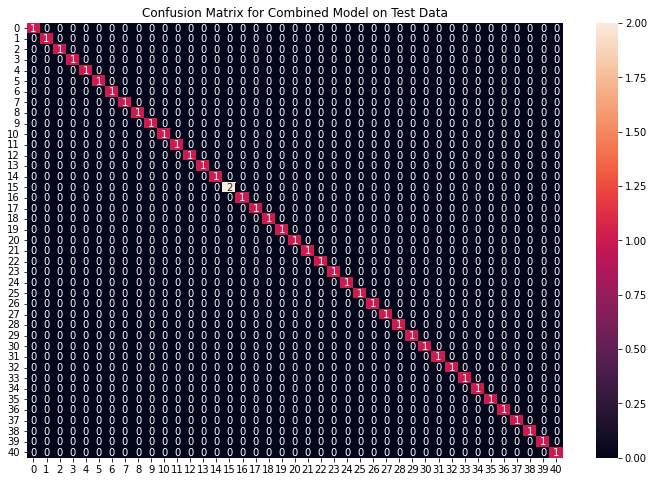

In [72]:
svm_preds = svm.predict(X_test)
nb_preds = nb.predict(X_test)
rf_preds = rf.predict(X_test)
# knn_preds = knn.predict(X_test)
final_preds = [mode([i,j,k])[0][0] for i,j,k, in zip(svm_preds, nb_preds, rf_preds)]
print(f"Accuracy on train data by Combined Model\
: {accuracy_score(y_train, nb.predict(X_train))*100}")

print(f"Accuracy on test data by Combined Model\
: {accuracy_score(y_test, final_preds)*100}")
cf_matrix = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Combined Model on Test Data")
plt.show()

In [75]:
symptoms = X.columns.values
 
# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index
 
data_dict = {
    "symptom_index":symptom_index,
    "predictions_classes":encoder.classes_
}
 
# Defining the Function
# Input: string containing symptoms separated by commmas
# Output: Generated predictions by models
def predictDisease(symptoms):
    symptoms = symptoms.split(",")
     
    # creating input data for the models
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1
         
    # reshaping the input data and converting it
    # into suitable format for model predictions
    input_data = np.array(input_data).reshape(1,-1)
     
    # generating individual outputs
    rf_prediction = data_dict["predictions_classes"][rf.predict(input_data)[0]]
    nb_prediction = data_dict["predictions_classes"][nb.predict(input_data)[0]]
    svm_prediction = data_dict["predictions_classes"][svm.predict(input_data)[0]]
     
    # making final prediction by taking mode of all predictions
    final_prediction = mode([nb_prediction,rf_prediction,svm_prediction])[0][0]
    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": nb_prediction,
        "Detected Disease" : final_prediction
    }
    return predictions
 
# Testing the function
print(predictDisease("Acidity,Anxiety,Burning Micturition,Chills"))

{'rf_model_prediction': 'Allergy', 'naive_bayes_prediction': 'Allergy', 'svm_model_prediction': 'Allergy', 'Detected Disease': 'Allergy'}


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


In [76]:
filename1 = 'DiseaseDetection(svm model).sav'
filename2 = 'DiseaseDetection(rf model).sav'
filename3 = 'DiseaseDetection(gaussian NB model).sav'
filename4 = 'DiseaseDetection(Encoder).sav'
pickle.dump(svm, open(filename1,'wb'))
pickle.dump(rf,open(filename2,'wb'))
pickle.dump(nb,open(filename3,'wb'))
pickle.dump(encoder,open(filename4,'wb'))